In [1]:
import numpy as np

In [2]:
import os

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
%config InlineBackend.figure_format='retina'

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import sys
# Don't generate the __pycache__ folder locally
sys.dont_write_bytecode = True 
# Print exception without the buit-in python warning
sys.tracebacklimit = 0 

In [5]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [7]:
from modules import *

from parameters import *

In [8]:
# Preprocess images and convert labels to integers

original_images, original_labels = preprocess_images(folder_paths, img_size)

Loading images:   0%|          | 0/600 [00:00<?, ?it/s]

Premature end of JPEG file


In [9]:
# Split data into training and testing sets, and convert labels to one-hot encoding

X_train, X_test, y_train_str, y_test_str = train_test_split(original_images, original_labels, 
                                                            test_size=split_percentage, random_state=42)

In [10]:
# Convert string labels to numerical labels

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train_str)

In [11]:
# Convert labels to one-hot encoding

num_classes = len(np.unique(original_labels))

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(label_encoder.transform(y_test_str), num_classes)

In [12]:
# Define the number of augmentations
n_augmentations = n_augmentations

# Define the image data generator and set the augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Initialize empty arrays to store the augmented images and their labels
X_train_augmented = np.zeros((X_train.shape[0] * n_augmentations, X_train.shape[1], 
                              X_train.shape[2], X_train.shape[3]))
y_train_augmented = np.zeros((y_train.shape[0] * n_augmentations, y_train.shape[1]))

# Loop over each image in X_train
for i in range(X_train.shape[0]):
    # Expand the dimensions of the image to make it compatible with the datagen.flow() method
    img = np.expand_dims(X_train[i], axis=0)
    
    # Generate n_augmentations augmented images for the current image
    augmented_images = datagen.flow(img, batch_size=n_augmentations, shuffle=False)
    
    # Store the augmented images in the X_train_augmented array
    X_train_augmented[i*n_augmentations:(i+1)*n_augmentations] = augmented_images[0]
    
    # Get the label of the current image
    label = y_train[i]
    
    # Repeat the label n_augmentations times and store it in the y_train_augmented array
    y_train_augmented[i*n_augmentations:(i+1)*n_augmentations] = np.tile(label, (n_augmentations, 1))

In [13]:
# Combine the original and augmented images

X_train_final = np.concatenate((X_train, X_train_augmented))

# Combine the original and augmented labels

y_train_final = np.concatenate((y_train, y_train_augmented))

In [14]:
# # Generate a random index to select a random image from X_train
# random_index = np.random.randint(0, X_train.shape[0])

# # Get the selected image and its label
# selected_image = X_train[random_index]
# selected_label = y_train[random_index]

# # Create a list of images that includes the selected image and its augmented images
# images = [selected_image]
# labels = ["Original Image (Class: {})".format(np.argmax(selected_label))]

# # Loop over each image in X_train_augmented that corresponds to the selected image
# for i in range(random_index*n_augmentations, (random_index+1)*n_augmentations):
#     # Get the augmented image and its label
#     augmented_image = X_train_augmented[i]
#     augmented_label = y_train_augmented[i]
    
#     # Add the augmented image and its label to the list of images
#     images.append(augmented_image)
#     labels.append("Augmented Image {} (Class: {})".format(i-random_index*n_augmentations+1, np.argmax(augmented_label)))
    
# # Plot the selected image and its augmented images
# plt.figure(figsize=(10, 10))
# for i in range(n_augmentations+1):
#     plt.subplot(n_augmentations+1, 1, i+1)
#     plt.imshow(images[i])
#     plt.title(labels[i])

# plt.tight_layout()
# plt.show()

In [15]:
# Clear tf backend

tf.keras.backend.clear_session()

In [16]:
# input_shape = X_train.shape[1:]
# model = create_model(input_shape, num_classes, learning_rate)

model = new_model(X_train_final, regularization = True)

In [17]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                                 
                                                        

In [18]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        
        history = model.fit(X_train_final, y_train_final, batch_size=batch_size, 
                            epochs=1, verbose=0, 
                            validation_data=(X_test, y_test))

        train_acc = history.history['accuracy'][0]
        val_acc = history.history['val_accuracy'][0]
        train_loss = history.history['loss'][0]
        val_loss = history.history['val_loss'][0]

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        pbar.set_description(f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        pbar.update(1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
# Generate predictions for the test data

y_pred = model.predict(X_test)

# Convert predictions to labels

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = np.argmax(y_test, axis=1)

2/2 [==============================] - 0s 9ms/step


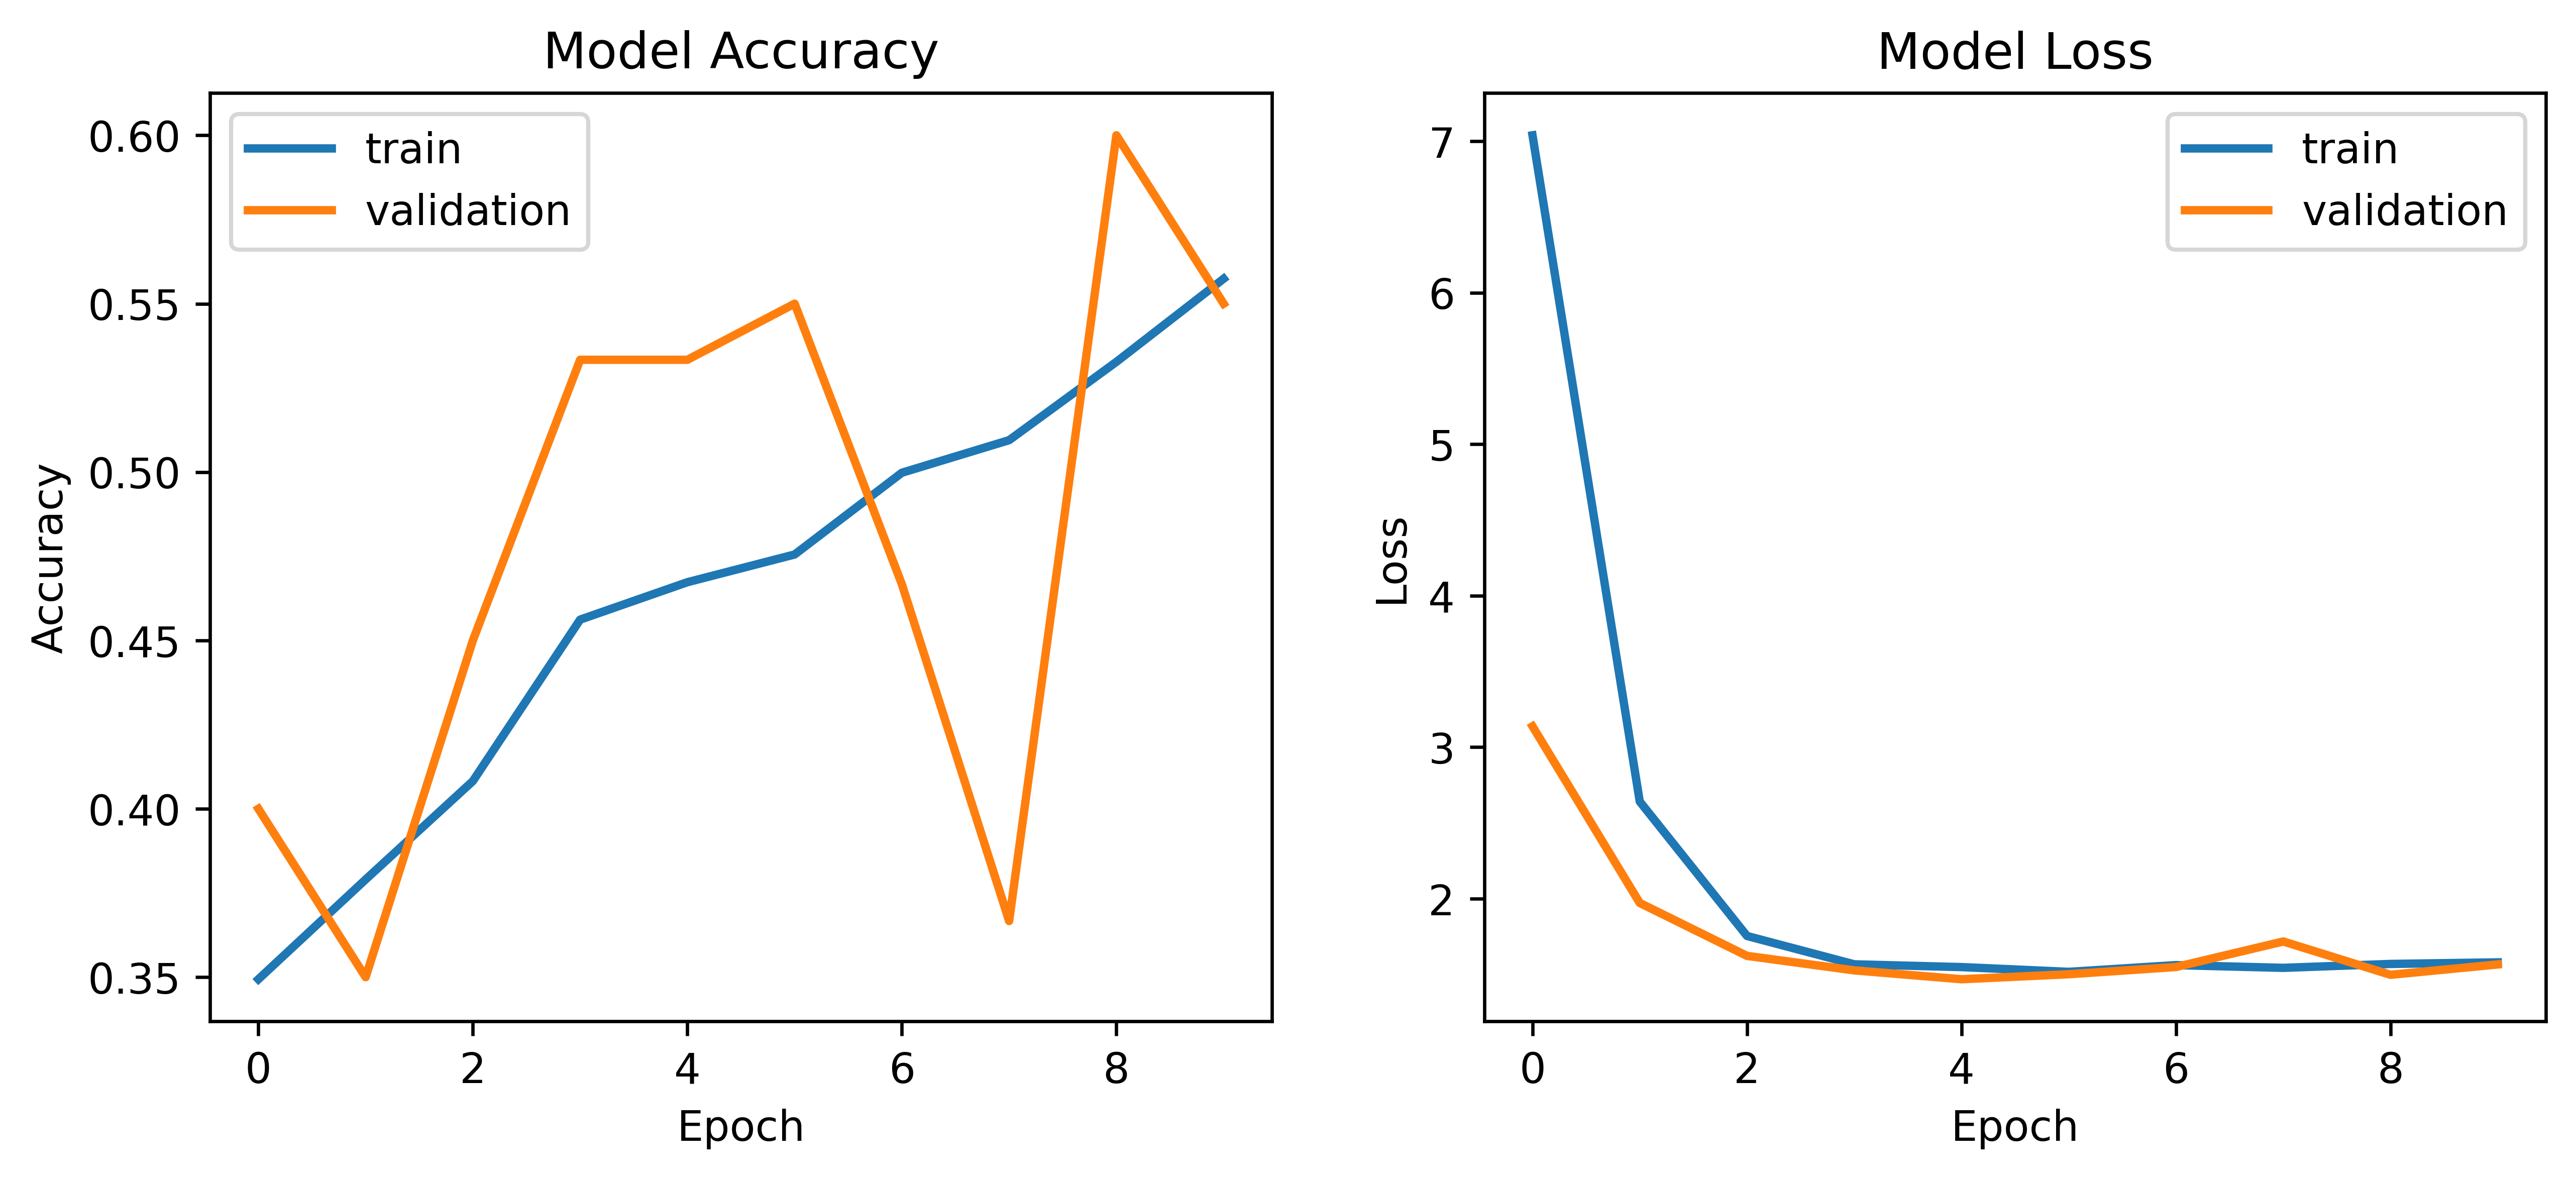

In [20]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi = 300)

# Plot training and validation accuracy over epochs
axs[0].plot(train_acc_list, linewidth=2)
axs[0].plot(val_acc_list, linewidth=2)
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['train', 'validation'], loc='best')

# Plot training and validation loss over epochs
axs[1].plot(train_loss_list, linewidth=2)
axs[1].plot(val_loss_list, linewidth=2)
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['train', 'validation'], loc='best')

# Show the plot
plt.show()

In [21]:
# Define class dictionary
class_dict = {0: 'group_1', 1: 'group_2', 2: 'group_3'}

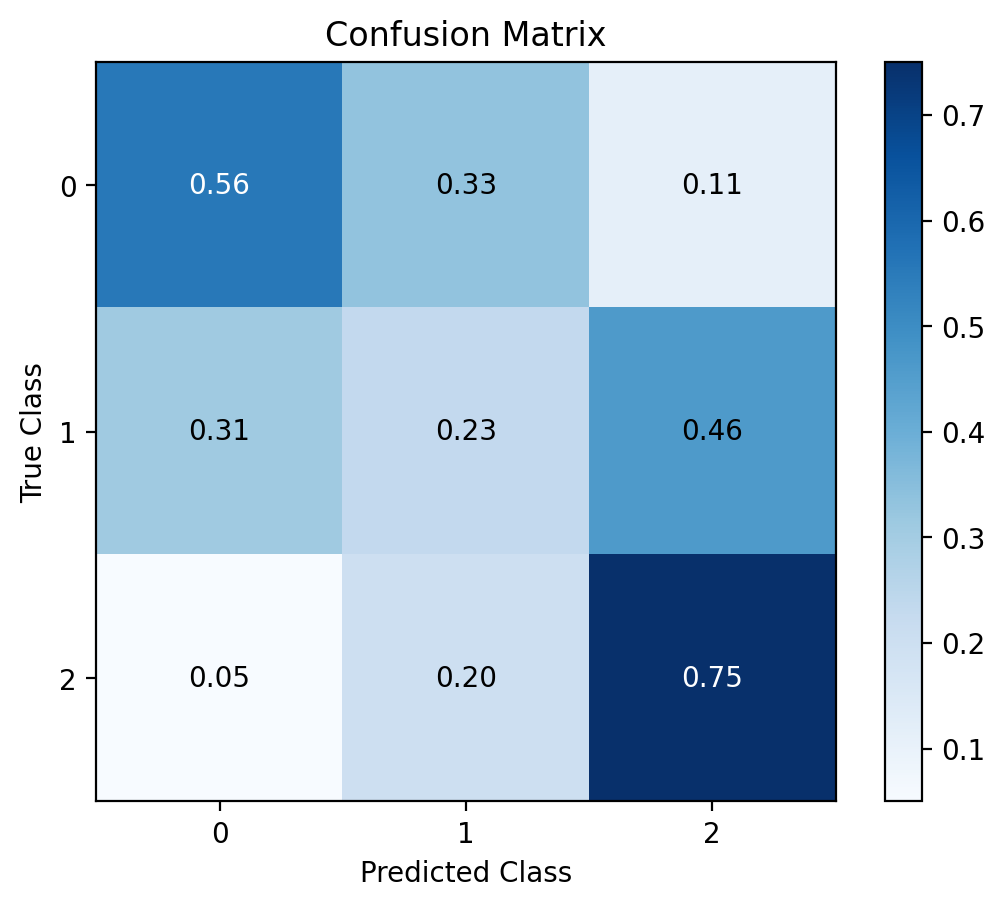

In [22]:
# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, normalize='true')

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap = 'Blues', interpolation = 'None')

ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))

ax.set_xticklabels(class_dict.keys())
ax.set_yticklabels(class_dict.keys())

ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')

ax.set_title('Confusion Matrix')

for i in range(num_classes):
    for j in range(num_classes):
        text = ax.text(j, i, format(cm[i, j], '.2f'),
                       ha="center", va="center", color="white" if cm[i, j] > 0.5 else "black")

plt.colorbar(im)
plt.show()

In [23]:
# Evaluate the model on the test data
score = model.evaluate(X_test, y_test, verbose=0)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert predictions from probabilities to labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calculate performance metrics
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Print performance metrics
print()
print(f'Test accuracy: {accuracy:.3f}')
print(f'Test precision: {precision:.3f}')
print(f'Test recall: {recall:.3f}')
print(f'Test F1-score: {f1:.3f}')
print()
print(f'Test confusion matrix:\n{cm}')
print()

2/2 [==============================] - 0s 9ms/step

Test accuracy: 0.550
Test precision: 0.586
Test recall: 0.550
Test F1-score: 0.559

Test confusion matrix:
[[15  9  3]
 [ 4  3  6]
 [ 1  4 15]]

